### Cmpe492 Using SHAP (SHapley Additive exPlanations) for explainable Alzheimer model
#### Alper Canberk Balcı - Advisor: İnci Meliha Baytaş
- 6/11/2022 Version 1.0


In [1]:
# A bunch of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import seaborn as sns
import math
from sklearn import linear_model, preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
import shap

C:\Users\Canbe\anaconda3\envs\bounAITask0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

In [2]:
x_train = np.load('temporal_data.npy', allow_pickle=True)
y_train = np.load('temporal_binary_label.npy', allow_pickle=True)
x_test = np.load('test_temporal_data.npy', allow_pickle=True)
y_test = np.load('test_temporal_binary_label.npy', allow_pickle=True)


In [3]:
x_train.shape

(845,)

In [4]:
x_train[0].shape
# It is now a temporal data but it will be transformed such that each time instant would be a data point.

(8, 15)

In [5]:
# Let's transform:
X_train = []
for i in range(len(x_train)):
    if i == 0:
        X_train = x_train[i]
    else:
        X_train = np.concatenate([X_train, x_train[i]])
        
Y_train = []
for i in range(len(y_train)):
    if i == 0:
        Y_train = y_train[i]
    else:
        Y_train = np.concatenate([Y_train, y_train[i]])
        
X_test = []
for i in range(len(x_test)):
    if i == 0:
        X_test = x_test[i]
    else:
        X_test = np.concatenate([X_test, x_test[i]])
        
Y_test = []
for i in range(len(y_test)):
    if i == 0:
        Y_test = y_test[i]
    else:
        Y_test = np.concatenate([Y_test, y_test[i]])

In [6]:
X_train.shape

(5460, 15)

In [7]:
X_train = pd.DataFrame(X_train, columns = ['Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp'])

In [8]:
X_test = pd.DataFrame(X_test, columns = ['Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp'])

### Inspect the data

In [9]:
X_train.info()
# 0:8 are cognitive test data, 9:14 are MRI data. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          5460 non-null   float32
 1   CDRSB        5460 non-null   float32
 2   ADASI1       5460 non-null   float32
 3   ADASI3       5460 non-null   float32
 4   MMSE         5460 non-null   float32
 5   RAVLT_im     5460 non-null   float32
 6   RAVLT_leam   5460 non-null   float32
 7   RVLT_for     5460 non-null   float32
 8   FAQ          5460 non-null   float32
 9   Ventricles   5460 non-null   float32
 10  Hippocampus  5460 non-null   float32
 11  WholeBrain   5460 non-null   float32
 12  Entorhinal   5460 non-null   float32
 13  Fusiform     5460 non-null   float32
 14  Midtemp      5460 non-null   float32
dtypes: float32(15)
memory usage: 320.0 KB


In [10]:
X_train.describe()

,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,0.509559,0.169551,0.203739,0.255574,0.848706,0.393680,0.434933,0.611986,0.257570,0.000608,0.000302,0.000243,0.000311,0.000287,0.000291
std,0.204212,0.168987,0.140331,0.148422,0.154325,0.159465,0.136176,0.088575,0.287431,0.013530,0.013532,0.013533,0.013532,0.013532,0.013532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.371508,0.055556,0.114286,0.152941,0.800000,0.293333,0.315789,0.555556,0.033333,0.000245,0.000092,0.000046,0.000095,0.000081,0.000084
50%,0.516760,0.111111,0.171429,0.223529,0.900000,0.373333,0.421053,0.629630,0.133333,0.000386,0.000117,0.000059,0.000129,0.000104,0.000110
75%,0.656424,0.222222,0.257143,0.333294,0.966667,0.493333,0.526316,0.666667,0.433333,0.000554,0.000143,0.000073,0.000160,0.000127,0.000132
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.946667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- The dataset is already prepared.
- It doesn't have any null values.
- It is normalized and all numeric. I can add two categorical features: Sex and Marital Status. Maybe later.

In [25]:
Y_train.sum()

1695

### Fit a linear logistic regression model

In [11]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")

In [12]:
logmodel.fit(X_train, Y_train)

LogisticRegression(max_iter=2000, penalty='l1', solver='saga', tol=0.001)

In [13]:
predictions = logmodel.predict(X_test)

In [14]:
predictions.sum()

481

In [15]:
score = logmodel.score(X_test,Y_test)
score

0.9180576631259484

### Statistics regarding the predictions

In [16]:
precision_recall_fscore_support(Y_test, predictions)
# Return value may look cryptic.
# It represents both classes 0 and 1 as positive class, as I didn't identify 1 as positive.
# Left column is for 0 as a positive class: precision = 0.903, recall = 0.966.
# Right column is for 1 as a positive class: precision = 0.944, recall = 0.849.

(array([0.90322581, 0.94386694]),
 array([0.96551724, 0.84859813]),
 array([0.93333333, 0.89370079]),
 array([783, 535], dtype=int64))

In [17]:
cm = confusion_matrix(Y_test, predictions)

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

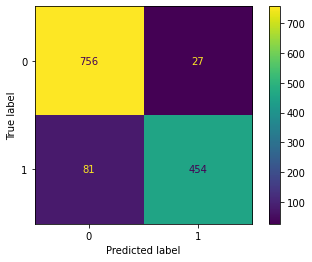

In [19]:
disp.plot()
# True Positive: 454
# True Negative: 756
# False Positive: 27
# False Negative: 81
# Now we can prove that return value I described by hand calculating precision and recall.

In [20]:
precision = 454 / (454+27)
recall = 454 / (454+81)
print(f"precision: {precision}, recall: {recall}")

precision: 0.9438669438669439, recall: 0.8485981308411215


- We have relatively low recall value: 0.849
- In diagnosis case low recall is a problem that needs to be solved.

### Explain the model and features using SHAP
 https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html
 
https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer

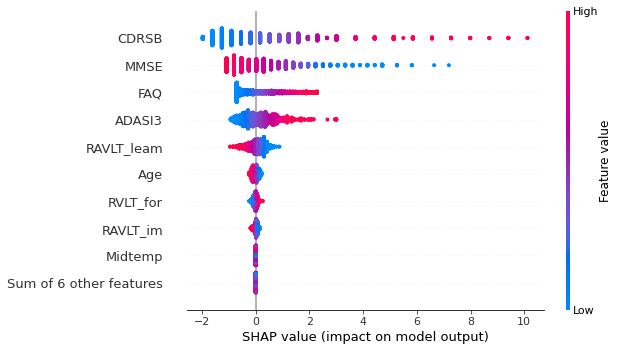

In [21]:
explainer = shap.Explainer(logmodel, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

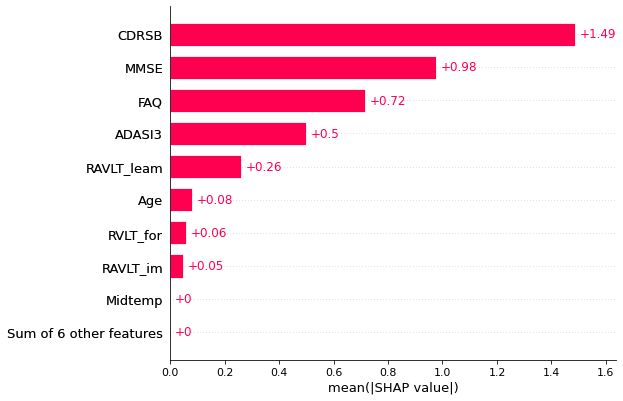

In [22]:
shap.plots.bar(shap_values)

In [23]:
shap.initjs()

In [27]:
ind = 16
shap.plots.force(shap_values[ind])

### XGBoost Trial

I want to try xgboost model as well. It is prone to overfitting, less easily interpreted. Trying it with SHAP may give some insight about modeling.

In [59]:
import xgboost as xgb

In [205]:
clf_xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                            booster="gbtree",
                            seed=11,
                            #num_class=2,
                            eta=0.154,
                            #gamma=0.25,
                            max_depth=16,
                            #min_child_weight=0.07,
                            #subsample=0.81,
                            reg_lambda=0.012,
                            #reg_alpha = 0.0009,
                            #max_bin = 650,
                            num_parallel_tree=5,
                            normalize_type="forest",
                            # tree_method = "hist",
                            # colsample_bytree=0.4,
                            eval_metric='rmse', #rmsle for outliers.
                            early_stopping_rounds = 10)
# sample_type = weighted , normalize_type = forest, rate_drop 0-1, ============ booster=dart
# colsample_bytree, colsample_bylevel, colsample_bynode 

clf_xgb2.fit(X_train,
            Y_train,
            # sample_weight=sample_weights,
            verbose=True,
            eval_set=[(X_test, Y_test)])


[17:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "normalize_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.44836
[1]	validation_0-rmse:0.40835
[2]	validation_0-rmse:0.37741
[3]	validation_0-rmse:0.35340
[4]	validation_0-rmse:0.33448
[5]	validation_0-rmse:0.32128
[6]	validation_0-rmse:0.30923
[7]	validation_0-rmse:0.30021
[8]	validation_0-rmse:0.29533
[9]	validation_0-rmse:0.29197
[10]	validation_0-rmse:0.28717
[11]	validation_0-rmse:0.28469
[12]	validation_0-rmse:0.28390
[13]	validation_0-rmse:0.28172
[14]	validation_0-rmse:0.28146
[15]	validation_0-rmse:0.28088
[16]	validation_0-rmse:0.28006
[17]	validation_0-rmse:0.27925
[18]	validation_0-rmse:0.2788

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=0.154,
              eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.153999999, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='forest', num_parallel_tree=5,
              predictor='auto', random_state=11, ...)

In [206]:
predict_XG = clf_xgb2.predict(X_test)

In [207]:
precision_recall_fscore_support(Y_test, predict_XG)

(array([0.89371981, 0.9122449 ]),
 array([0.94508301, 0.83551402]),
 array([0.91868405, 0.87219512]),
 array([783, 535], dtype=int64))

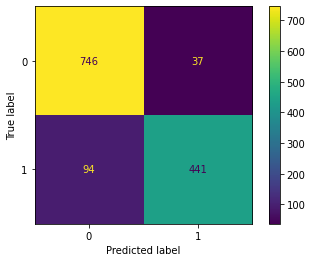

In [186]:
cm = confusion_matrix(Y_test, predict_XG)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# True Positive: 454
# True Negative: 756
# False Positive: 27
# False Negative: 81

- XGBoost precision and recall is worse than the logistic regression. Maybe it needs some hyperparameter tuning.
- precision, recall
- 0.92,       0.81682243 - max_depth=7
- 0.89759036, 0.83551402 - max_depth=9
- 0.92386831, 0.83925234 - max_depth=11
- 0.90981964, 0.84859813 - 13 (recall same with logistic regression)
- 0.92008197, 0.83925234 - 15
- 0.90361446, 0.8411215  - 16, 17, and so on
- 0.91836735, 0.8411215  - 16, reg_lambda=0.012,
- 0.92213115, 0.8411215  - 16, reg_lambda=0.012, subsample=0.7
- 0.92622951, 0.84485981 - 16, reg_lambda=0.012, subsample=0.87, though it may be overfit sample as other values doesn't represent a trustworthy outputs.
- 0.92050209, 0.82242991 - I changed the seed to prove my point.
- 0.92901879, 0.8317757  - subsample=0.81, for example. it is better for this seed.
- 0.91836735, 0.8411215  - without subsample, seed is not important.
- 0.92260692, 0.84672897 - seed=11, eta=0.15, max_depth=16, reg_lambda=0.012,
- I give up. Not worth to try more. It is close to logistic regression. 
- Now try the SHAP for xgboost.





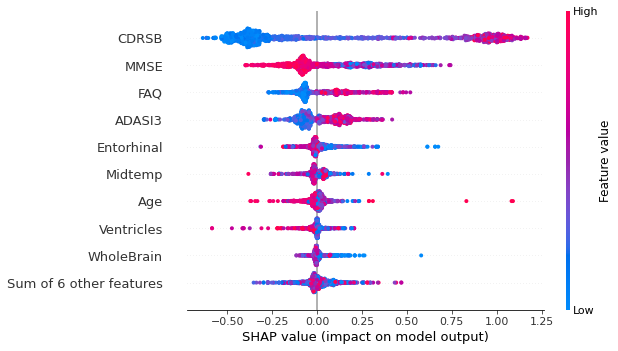

In [242]:
explainer = shap.TreeExplainer(clf_xgb2, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)
# It gives a different SHAP values.
# https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook

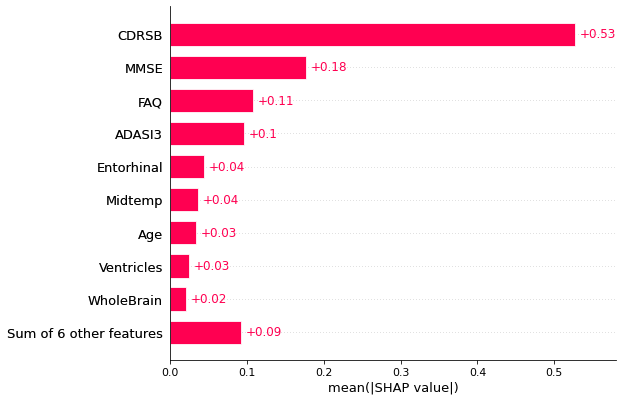

In [210]:
shap.plots.bar(shap_values)

- For now, I delay another model, especially non-linear, deep models. 
- Let's focus on the features.
- Divide the features into two and train with each alone. Cognitive ones, MRI ones.

### Cognitive features alone

In [221]:
X_train_cogn = pd.DataFrame(X_train, columns = ['Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ'])
X_test_cogn = pd.DataFrame(X_test, columns = ['Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ'])

In [229]:
X_train_cogn.describe()

,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,0.509559,0.169551,0.203739,0.255574,0.848706,0.393680,0.434933,0.611986,0.257570
std,0.204212,0.168987,0.140331,0.148422,0.154325,0.159465,0.136176,0.088575,0.287431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.371508,0.055556,0.114286,0.152941,0.800000,0.293333,0.315789,0.555556,0.033333
50%,0.516760,0.111111,0.171429,0.223529,0.900000,0.373333,0.421053,0.629630,0.133333
75%,0.656424,0.222222,0.257143,0.333294,0.966667,0.493333,0.526316,0.666667,0.433333
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.946667,1.000000,1.000000,1.000000


In [226]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel.fit(X_train_cogn, Y_train)
predictions = logmodel.predict(X_test_cogn)

In [228]:
score = logmodel.score(X_test_cogn,Y_test)
score # same score with all features

0.9180576631259484

In [230]:
precision_recall_fscore_support(Y_test, predictions)  # same score with all features

(array([0.90322581, 0.94386694]),
 array([0.96551724, 0.84859813]),
 array([0.93333333, 0.89370079]),
 array([783, 535], dtype=int64))

### Explain the model and *cognitive* features using SHAP

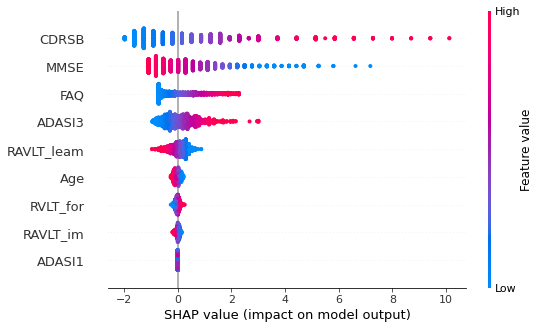

In [231]:
explainer = shap.Explainer(logmodel, X_train_cogn)
shap_values = explainer(X_test_cogn)
shap.plots.beeswarm(shap_values)

### MRI features alone

In [232]:
X_train_MRI = pd.DataFrame(X_train, columns = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp'])
X_test_MRI = pd.DataFrame(X_test, columns = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp'])

In [233]:
X_train_MRI.describe()

,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,0.000608,0.000302,0.000243,0.000311,0.000287,0.000291
std,0.013530,0.013532,0.013533,0.013532,0.013532,0.013532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000245,0.000092,0.000046,0.000095,0.000081,0.000084
50%,0.000386,0.000117,0.000059,0.000129,0.000104,0.000110
75%,0.000554,0.000143,0.000073,0.000160,0.000127,0.000132
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [234]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel.fit(X_train_MRI, Y_train)
predictions = logmodel.predict(X_test_MRI)

In [235]:
score = logmodel.score(X_test_MRI,Y_test)
score # worse

0.5940819423368741

In [239]:
precision_recall_fscore_support(Y_test, predictions, zero_division=0)  # WORSE

(array([0.59408194, 0.        ]),
 array([1., 0.]),
 array([0.74535935, 0.        ]),
 array([783, 535], dtype=int64))

- With only MRI features, model interpret all data points as not alzheimer.

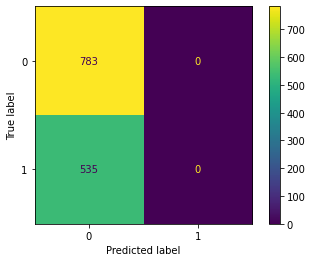

In [240]:
cm = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Explain the model and *MRI* features using SHAP

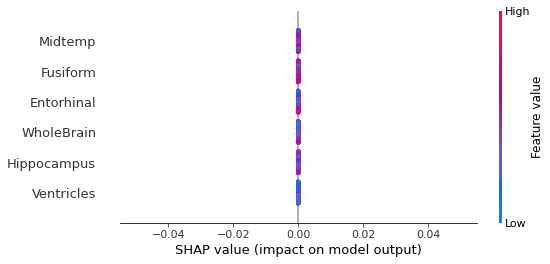

In [241]:
explainer = shap.Explainer(logmodel, X_train_MRI)
shap_values = explainer(X_test_MRI)
shap.plots.beeswarm(shap_values)

- To be honest, I didn't expect this. I finish my study for now.